In [2]:
import sys

sys.path.append("..")
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

config = OmegaConf.load("../configs/example_training/svd_interpolation_cross_audio.yaml")
print(config)
config["model"]["params"]["ckpt_path"] = "../checkpoints/svd.safetensors"
video_model = instantiate_from_config(config.model)

{'model': {'base_learning_rate': 3e-05, 'target': 'sgm.models.diffusion.DiffusionEngine', 'params': {'input_key': 'latents', 'no_log_keys': ['audio_emb', 'fps_id', 'motion_bucket_id', 'cond_aug', 'valence', 'arousal'], 'scale_factor': 0.18215, 'disable_first_stage_autocast': True, 'ckpt_path': 'checkpoints/svd_no_emb.safetensors', 'remove_keys_from_weights': ['model.diffusion_model.input_blocks.0.0.weight', 'model.diffusion_model.label_emb.0.0.weight'], 'compile_model': False, 'scheduler_config': {'target': 'sgm.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [1000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}, 'to_freeze': [], 'to_unfreeze': [], 'use_lora': False, 'lora_config': {'search_class_str': 'Linear', 'target_replace_module': None, 'r_linear': 16, 'r_conv': 16, 'loras': None}, 'denoiser_config': {'target': 'sgm.modules.diffusionmodules.denoiser.Denoiser', 'params': {'scaling_config': {'target': 'sgm.modules.diffusion

In [3]:
video_model

DiffusionEngine(
  (model): InterpolationWrapper(
    (diffusion_model): VideoUNet(
      (time_embed): Sequential(
        (0): Linear(in_features=320, out_features=1280, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (label_emb): Sequential(
        (0): Sequential(
          (0): Linear(in_features=1024, out_features=1280, bias=True)
          (1): SiLU()
          (2): Linear(in_features=1280, out_features=1280, bias=True)
        )
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(9, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): VideoResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd):

In [ ]:
from safetensors.torch import load_file as load_safetensors

latents = load_safetensors(
    "/data/home/antoni/code/generative-models/custom_inputs/identities/alex_cropped_video_512_latent.safetensors"
)["latents"]

In [3]:
from torchvision.io import read_video
import torch

video_path = "/fsx/behavioural_computing_data/face_generation_data/AA_processed/part_1/video_crop/G185_C011_0222NS_001_output_output.mp4"
resolution = 64
device = torch.device("cuda")

video, audio, info = read_video(video_path, pts_unit="sec", output_format="TCHW", end_pts=100)

from torchvision.transforms import Resize

resize = Resize((resolution, resolution))
video = resize(video)
print(video.shape)

/data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([6001, 3, 64, 64])


In [4]:
video_norm = video / 255.0
video_norm = video_norm * 2 - 1

In [3]:
video_norm.max(), video_norm.min()

(tensor(0.6235), tensor(-1.))

In [7]:
import lpips

loss_fn_alex = lpips.LPIPS(net="vgg")  # best forward scores
import random

sum_ = 0
for i in range(1000):
    idx_1 = random.randint(0, len(video) - 1)
    idx_2 = random.randint(0, len(video) - 1)
    d = loss_fn_alex(video_norm[idx_1].unsqueeze(0), video_norm[idx_2].unsqueeze(0))
    sum_ += d.item()
print(sum_ / 1000)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Loading model from: /data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
0.18908137297257782


In [ ]:
audio_path = "/data2/Datasets/HDTF/audio/WRA_BobbySchilling_001_whisper_emb.pt"
audio = torch.load(audio_path)
print(audio.shape)

In [ ]:
video.min(), video.max()

In [ ]:
model.first_stage_model.encoder

In [ ]:
model = model.to(device)
encoded = model.conditioner.embedders[3]((video[:2].to(device).float() / 255.0) * 2 - 1)

In [2]:
from safetensors.torch import load_file

encoded = load_file(
    "/fsx/behavioural_computing_data/face_generation_data/AA_processed/part_1/video_512_latent/G185_C011_0222NS_001_output_output_video_512_latent.safetensors"
)["latents"][:6000]
encoded.shape

torch.Size([6000, 4, 64, 64])

In [10]:
encoded.min(), encoded.mean()

(tensor(-16.5984), tensor(0.2486))

In [14]:
import torch


def rgba_to_rgb(rgba_tensor, method="ignore", background_color=(1.0, 1.0, 1.0)):
    """
    Convert an RGBA tensor to an RGB tensor.

    Parameters:
    - rgba_tensor (torch.Tensor): Input tensor of shape (4, H, W) representing RGBA image.
    - method (str): Method to use for conversion. Options are 'ignore', 'average', or 'composite'.
      - 'ignore': Simply drop the alpha channel.
      - 'average': Average with a white background using the alpha channel.
      - 'composite': Blend with a specified background color using the alpha channel.
    - background_color (tuple): RGB tuple specifying the background color for 'composite' method.

    Returns:
    - torch.Tensor: Output tensor of shape (3, H, W) representing RGB image.
    """

    if rgba_tensor.shape[0] != 4:
        raise ValueError("Input tensor must have 4 channels (RGBA).")

    # Extract RGBA channels
    r, g, b, a = rgba_tensor[0], rgba_tensor[1], rgba_tensor[2], rgba_tensor[3]

    if method == "ignore":
        # Ignore the alpha channel
        rgb_tensor = rgba_tensor[:3, :, :]

    elif method == "average":
        # Average with a white background
        rgb_tensor = torch.stack(
            [
                r * a + (1 - a),  # Red channel
                g * a + (1 - a),  # Green channel
                b * a + (1 - a),  # Blue channel
            ],
            dim=0,
        )

    elif method == "composite":
        # Ensure background_color is a valid RGB tuple
        if len(background_color) != 3:
            raise ValueError("Background color must be an RGB tuple of length 3.")

        background_color = torch.tensor(background_color).view(3, 1, 1)

        # Composite with a specified background color
        rgb_tensor = torch.stack(
            [
                r * a + background_color[0] * (1 - a),  # Red channel
                g * a + background_color[1] * (1 - a),  # Green channel
                b * a + background_color[2] * (1 - a),  # Blue channel
            ],
            dim=0,
        )

    else:
        raise ValueError("Method must be one of 'ignore', 'average', or 'composite'.")

    return rgb_tensor

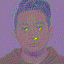

In [5]:
image = (encoded[0] * 0.18215).clip(-1, 1)
image = ((image.cpu() + 1) / 2) * 255
from PIL import Image

image_rgb = image[:3]

Image.fromarray(image_rgb.permute(1, 2, 0).numpy().astype("uint8"))

In [9]:
import lpips

loss_fn_alex = lpips.LPIPS(net="vgg")  # best forward scores
import random


sum_ = 0
for i in range(1000):
    idx_1 = random.randint(0, len(encoded) - 1)
    idx_2 = random.randint(0, len(encoded) - 1)
    d = loss_fn_alex(
        (encoded[idx_1, :3].unsqueeze(0) * 0.18215).clip(-1, 1),
        (encoded[idx_2, :3].unsqueeze(0) * 0.18215).clip(-1, 1),
    )
    sum_ += d.item()
print(sum_ / 1000)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Loading model from: /data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
0.12350337564013898


In [11]:
d.shape

torch.Size([1, 1, 1, 1])

In [1]:
from diffusers.models import AutoencoderKL

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-mse",
)

/data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from safetensors.torch import load_file as load_safetensors

latents = load_safetensors(
    "/data/home/antoni/code/generative-models/custom_inputs/identities/alex_cropped_video_512_latent.safetensors"
)["latents"]

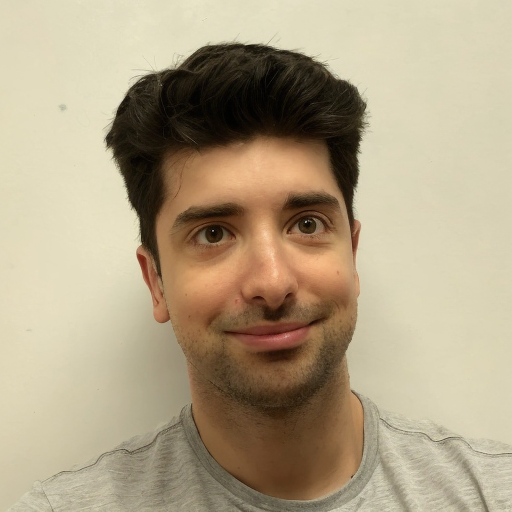

In [6]:
import torch
import numpy as np
from PIL import Image

encoded = latents[:2]

with torch.no_grad():
    decoded = vae.decode((1 / 0.18215) * encoded[:2]).sample
img = Image.fromarray(np.uint8((decoded[0].detach().clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

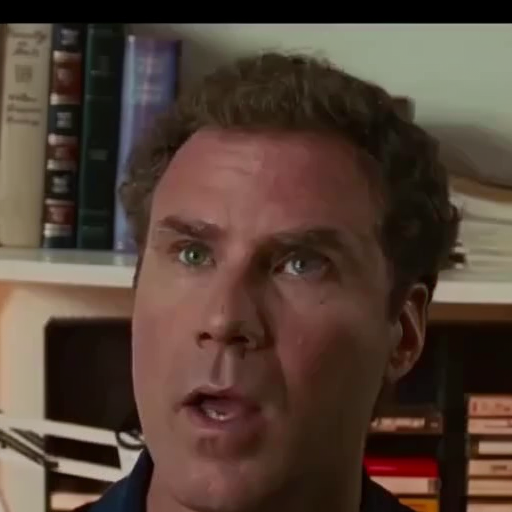

In [22]:
aud = torch.load(
    "/fsx/behavioural_computing_data/face_generation_data/AA_processed/part_1/audio_emb/G185_C011_0222NS_001.pt"
)
aud.shape[0], 7468 * (25 / 60)

(3097, 3111.666666666667)

In [21]:
def convert_indexes(indexes_25fps, fps_from=25, fps_to=60):
    ratio = fps_to / fps_from
    indexes_60fps = [int(index * ratio) for index in indexes_25fps]
    return indexes_60fps


# Example usage:
indexes_60fps = list(range(14))  # Example indexes at 60 FPS
indexes_25fps = convert_indexes(indexes_60fps)
print(indexes_25fps)

[0, 2, 4, 7, 9, 12, 14, 16, 19, 21, 24, 26, 28, 31]


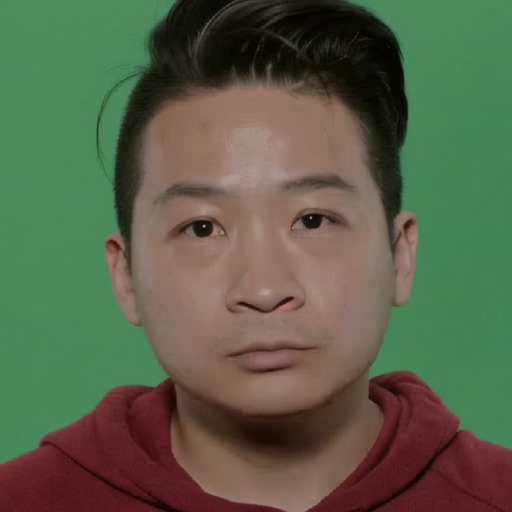

In [4]:
from PIL import Image
import numpy as np
import torch

# video_model.to(device)
# decoded = video_model.decode_first_stage(encoded[:, 4:])
with torch.no_grad():
    decoded = video_model.decode_first_stage(encoded[:2])
img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [ ]:
from safetensors.torch import load_file

latent_path = "/vol/bitbucket/abigata/00190_video_512_latent.safetensors"

latent = load_file(latent_path)
latent["latents"].shape

In [ ]:
decoded = video_model.decode_first_stage(latent["latents"][:1].to("cpu"))

In [ ]:
from PIL import Image
import numpy as np

img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [ ]:
import sys

sys.path.append("..")
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

config = OmegaConf.load(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/configs/inference/sd_2_1.yaml"
)
print(config)
config["model"]["params"]["ckpt_path"] = (
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/checkpoints/v2-1_512-ema-pruned.safetensors"
)
model = instantiate_from_config(config.model)

In [ ]:
from torchvision.io import read_video
import torch

video_path = "/data2/Datasets/HDTF/cropped_videos_original/WRA_BobbySchilling_001.mp4"
resolution = 512
device = torch.device("cuda:4")

video, audio, info = read_video(video_path, pts_unit="sec", output_format="TCHW")

from torchvision.transforms import Resize

resize = Resize((resolution, resolution))
video = resize(video)
print(video.shape)

In [ ]:
model.to(device)
encoded = model.encode_first_stage((video[:2].to(device).float() / 255.0) * 2 - 1)

In [ ]:
# decoded = model.decode_first_stage(encoded)
decoded = model.decode_first_stage(latent["latents"][:1].to(device))

In [ ]:
from PIL import Image
import numpy as np

img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h", cache_dir="/vol/bitbucket/abigata/.cache")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h", cache_dir="/vol/bitbucket/abigata/.cache")

In [ ]:
import torchaudio

audio_path = "/data2/Datasets/HDTF/audio/WRA_JeffFlake_001.wav"
audio, sr = torchaudio.load(audio_path)

In [ ]:
audio.shape

In [ ]:
from einops import rearrange

audio_reshaped = rearrange(audio.mean(0)[:640000], "(f s) -> f s", s=320)
audio_reshaped.shape

In [ ]:
processed = processor(audio=audio_reshaped, sampling_rate=sr, return_tensors="pt", padding="longest").input_values

In [ ]:
processed.shape

In [ ]:
import torch

normed_slice = (audio - audio.mean()) / torch.sqrt(audio.var() + 1e-7)

In [ ]:
normed_slice.shape

In [ ]:
with torch.no_grad():
    outs = model(normed_slice[:, : 16000 * 3], output_hidden_states=True)
    # hidden_states = model.wav2vec2(normed_slice)

In [ ]:
outs.logits.shape

In [ ]:
from einops import rearrange

rearanged = rearrange(hidden_states[0], "() (f d) c -> f d c", d=2)

In [ ]:
rearanged[1]

In [ ]:
outs.hidden_states[-1][:, 2:4]

In [ ]:
from torchvision.io import read_video

video_path = "/data2/Datasets/HDTF/cropped_videos_original/WRA_JeffFlake_001.mp4"
resolution = 512
device = torch.device("cuda:4")

video, audio, info = read_video(video_path, pts_unit="sec", output_format="TCHW")
video.shape

In [ ]:
outs.logits.shape, 7500 * 2

In [ ]:
predicted_ids = torch.argmax(outs.logits, dim=-1).squeeze()

# transcribe
transcription = processor.decode(predicted_ids)
transcription

In [ ]:
"NTRIES HAVE NEVER HAD FOR A SINGLE DAY IN THEIR LIVES BUT THE STORY OF THE PAST THREE AND A HALF YEARS IS A STORY OF THE POWER THAT WE VEST IN THE PRESIDENCY"

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h", cache_dir="/vol/bitbucket/abigata/.cache")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h", cache_dir="/vol/bitbucket/abigata/.cache")

In [ ]:
model

In [ ]:
import torch
from einops import rearrange

audio_emb = torch.load("/data2/Datasets/VoxCeleb2/video/dev/mp4/id07085/NcpRWNyzlAA/00031_wav2vec2_emb.pt")
audio_emb = rearrange(audio_emb, "f d c -> (f d) c")

In [ ]:
logits = model.lm_head(audio_emb).unsqueeze(0)
predicted_ids = torch.argmax(logits, dim=-1).squeeze()

# transcribe
transcription = processor.decode(predicted_ids)
transcription

In [ ]:
# Plot video
import moviepy.editor as mp

mp.VideoFileClip("/vol/paramonos/datasets/VoxCeleb2/video/dev/mp4/id07085/NcpRWNyzlAA/00031.mp4").ipython_display()